# OptiMask: Efficient Python Package for NaN Data Removal

Introducing OptiMask, a Python package designed to simplify the process of removing NaN (Not-a-Number) data from matrices while efficiently computing the largest submatrix without NaN. OptiMask focuses on providing immediate results, seamless compatibility with both Numpy arrays and Pandas DataFrames, and a user-friendly experience.

Highlights:

- NaN Data Removal: OptiMask streamlines the removal of NaN data from matrices, ensuring data integrity.
- Largest Submatrix: OptiMask computes the largest submatrix without NaN, enhancing data analysis accuracy.
- Swift Computation: With its fast computation, OptiMask swiftly generates results without unnecessary delays.
- Numpy and Pandas: Whether you use Numpy or Pandas, OptiMask adapts to your preferred data structure.
- Simplicity: OptiMask boasts a straightforward Python interface, making it easy for users of all levels to navigate.

Discover the efficiency of NaN data removal and submatrix optimization with OptiMask. Enhance your data processing workflows with a tool that prioritizes accuracy and simplicity

Cyril Joly

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from optimask import OptiMask

In [4]:
def plot(*data, figsize=None, show=True):
    n = len(data)
    cmap = plt.get_cmap("Spectral_r")
    cmap.set_bad('grey')
    plt.figure(figsize=figsize)
    for k, m in enumerate(data):
        plt.subplot(1, n, k+1)
        plt.pcolormesh(np.clip(m, 0, 1), cmap=cmap)
        plt.gca().axis('off')
        plt.gca().set_aspect('equal')
    if show:
        plt.show()


def generate_random(m, n, ratio):
    total_elements = m * n
    nan_count = int(ratio * total_elements)
    if nan_count > total_elements:
        raise ValueError("Le ratio est trop élevé, il doit être inférieur ou égal à 1.0")
    data = np.zeros((m, n))
    nan_indices = np.random.choice(total_elements, nan_count, replace=False)
    data.flat[nan_indices] = np.nan
    return data


def plot_rectange(xy, width, height):
    plt.gca().add_patch(Rectangle(xy=xy, width=width, height=height, ec='r', fc='none', linestyle="dashed"))

## 1. Understanding the Problem at Hand

In the context of a matrix containing a lone NaN cell, the central challenge emerges: determining whether to eliminate the corresponding row or column. This decision is readily resolved by examining the matrix's shape. Specifically, if the matrix has a greater number of rows than columns, the optimal approach involves removing the associated row. Conversely, when the matrix has more columns than rows, the most effective course of action is to eliminate the corresponding column:

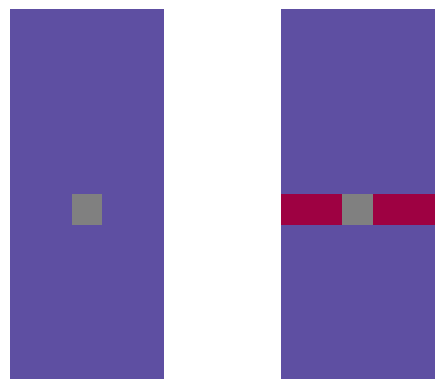

In [3]:
m, n = 12, 5

data = np.zeros((m, n))
data[5, 2] = np.nan
processed_data = data.copy()
processed_data[5] += 1

plot(data, processed_data)

Eliminating the highlighted row yields the most extensive submatrix devoid of NaN. This solution remains applicable even when additional NaN values are present within the same row:

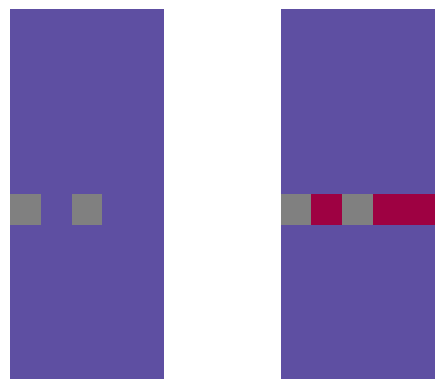

In [4]:
m, n = 12, 5

data = np.zeros((m, n))
data[5, [0, 2]] = np.nan
processed_data = data.copy()
processed_data[5] += 1

plot(data, processed_data)

But how about varying NaN patterns?

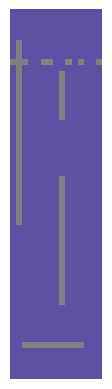

In [5]:
m, n = 60, 15

data = np.zeros((m, n))
data[5, 2:12] = np.nan
data[51, [0, 2, 5, 6, 9, 11, 14]] = np.nan
data[12:33, 8] = np.nan
data[42:50, 8] = np.nan
data[25:55, 1] = np.nan

plot(data)

Later we'll see the optimal solution is to remove two rows and two columns :

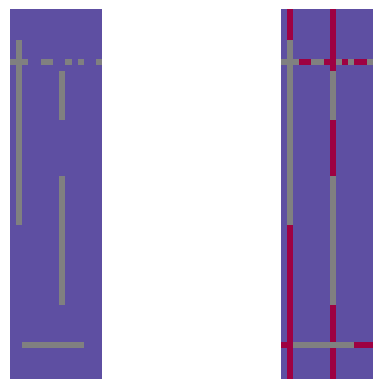

In [6]:
processed_data = data.copy()
processed_data[5] += 1
processed_data[51] += 1
processed_data[:, 1] += 1
processed_data[:, 8] += 1

plot(data, processed_data)

How can we achieve this result?

## 2. The Problem from an Optimization Perspective

This problem can be formalized as a binary optimization problem in two ways.

### 2.1. Linear programming

Source : [this mathematica.stackexchange answer](https://mathematica.stackexchange.com/a/108513/92680), posted by [unlikely](https://mathematica.stackexchange.com/users/16267/unlikely).

Given:

- Matrix $A$ of shape $m \times n$ and elements $a_{i,j}$
- The goal is to determine the values of variables $(i \in [1~..~m]$, $j \in [1~..~n])$:
  - $e_{i,j} \in \{0,1\}$ (1 if element $(i,j)$ should be removed, 0 otherwise)
  - $r_i \in \{0,1\}$ (1 if row $i$ should be removed, 0 otherwise)
  - $c_j \in \{0,1\}$ (1 if column $j$ should be removed, 0 otherwise)



Subject to:


- $e_{i,j} = 1$ for every $(i,j)$ such that $a_{i,j}$ is a NaN
- $r_i + c_j \geq e_{i,j}$, meaning if $e_{i,j} = 1$ then either $r_i = 1$ or $c_j = 1$, or both
- $e_{i,j} \geq r_i$, indicating if $r_i = 1$ then $e_{i,j}$ must be 1
- $e_{i,j} \geq c_j$, indicating if $c_j = 1$ then $e_{i,j}$ must be 1

The objective is to minimize the total number of remaining cells:

$$\sum_{i=1}^{m} \sum_{j=1}^{n} e_{i,j}$$

The optimal values of $r_i$ and $c_j$ provide us with the specific rows and columns to remove, ensuring that the remaining matrix is efficiently processed and devoid of NaN values. This problem can be solved in Python using the usual tools of linear programming, such as combining Pyomo with GLPK. Its disadvantage is being relatively expensive, as for an $m \times n$ matrix, more than $m \times n$ (binary) variables are used.

### 2.2. Quadratic Programming

By employing the variables mentioned earlier, an alternate perspective of the problem involves maximizing $$(m-\sum_{i=1}^m r_i) \times (n-\sum_{i=1}^n c_j)$$
while considering:
- $r_i + c_j \ge 1$ for each $(i,j)$ where $a_{i,j}$ is a NaN.

Although the number of variables is reduced, the optimization problem becomes more challenging.

## 3. An (exact?) heuristic

The heuristic involves finding the appropriate row and column permutations to simplify the problem into finding the largest contiguous rectangle without NaN.

A first step of permutating columns and rows is carried out, based on the number of NaN cells in each row/column.A first step of permutating columns and rows is carried out, based on the number of NaN cells in each row/column:

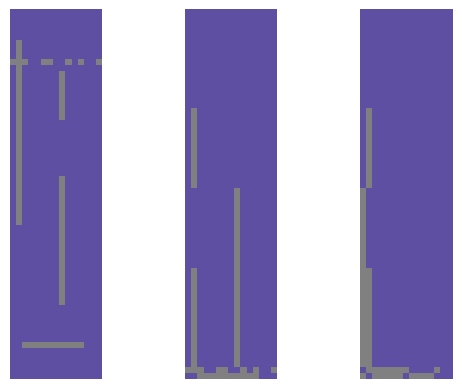

In [7]:
first_permutation_cols = OptiMask._sort_by_na_number(np.isnan(data), axis=0)
first_permutation_rows = OptiMask._sort_by_na_number(np.isnan(data), axis=1)

plot(data, data[first_permutation_rows], data[first_permutation_rows][:, first_permutation_cols])

The second step involves sorting based on the maximum index in the row/column of the last NaN cell. Thus, for two columns with the same number of NaN cells, the column with the highest NaN cell will be placed to the left. Similarly, for two rows with the same number of NaN cells, the row with the rightmost NaN cell will be placed at the bottom:

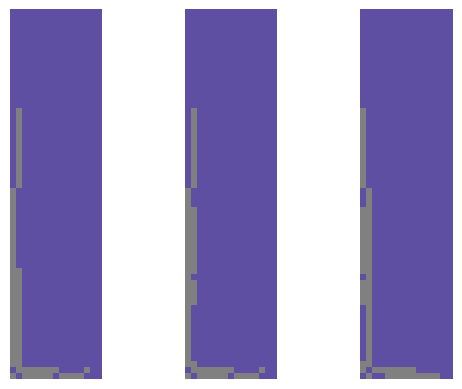

In [8]:
processed_data = data[first_permutation_rows][:, first_permutation_cols]

second_permutation_cols = OptiMask._sort_by_na_max_index(np.isnan(processed_data), axis=0)
second_permutation_rows = OptiMask._sort_by_na_max_index(np.isnan(processed_data[:, second_permutation_cols]), axis=1)
plot(processed_data, processed_data[second_permutation_rows], processed_data[second_permutation_rows][:, second_permutation_cols])

Finally, it is necessary to identify the largest rectangle without NaN, starting from the upper-right corner, and identify the rows and columns excluded by this rectangle. The calculation of this largest rectangle is straightforward. The permutations then allow us to revert to the rows and columns that should be excluded from the original matrix.Finally, it is necessary to identify the largest rectangle without NaN, starting from the upper-right corner, and identify the rows and columns excluded by this rectangle. The calculation of this largest rectangle is straightforward. The permutations then allow us to revert to the rows and columns that should be excluded from the original matrix.


## 4. Using OptiMask

OptiMask carries out all of these steps automatically and swiftly. The algorithmic cost is extremely low, and calling the `solve` method is extremely fast.

In [9]:
%time rows, cols = OptiMask.solve(data=data)
rows, cols

CPU times: total: 0 ns
Wall time: 997 µs


(array([ 0,  1,  2,  3,  4,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 52,
        53, 54, 55, 56, 57, 58, 59], dtype=int64),
 array([ 0,  2,  3,  4,  5,  6,  7,  9, 10, 11, 12, 13, 14], dtype=int64))

As we can see, the algorithm has removed one row and one columns :

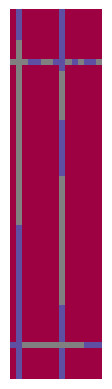

In [10]:
data_processed = data.copy()
data_processed[rows] += 1
data_processed[:, cols] += 1

plot(data_processed-1)

The class works also fine with `pd.DataFrame` objects :

In [11]:
df = pd.DataFrame(data, columns=[f'feature {k+1}' for k in range(n)], index=pd.date_range(start='2023-08-1', periods=m, freq='H'))
df.sample(3)

,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6,feature 7,feature 8,feature 9,feature 10,feature 11,feature 12,feature 13,feature 14,feature 15
2023-08-01 17:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0
2023-08-03 11:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-08-02 01:00:00,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
index, columns = OptiMask.solve(df)
index, columns

(DatetimeIndex(['2023-08-01 00:00:00', '2023-08-01 01:00:00',
                '2023-08-01 02:00:00', '2023-08-01 03:00:00',
                '2023-08-01 04:00:00', '2023-08-01 06:00:00',
                '2023-08-01 07:00:00', '2023-08-01 08:00:00',
                '2023-08-01 09:00:00', '2023-08-01 10:00:00',
                '2023-08-01 11:00:00', '2023-08-01 12:00:00',
                '2023-08-01 13:00:00', '2023-08-01 14:00:00',
                '2023-08-01 15:00:00', '2023-08-01 16:00:00',
                '2023-08-01 17:00:00', '2023-08-01 18:00:00',
                '2023-08-01 19:00:00', '2023-08-01 20:00:00',
                '2023-08-01 21:00:00', '2023-08-01 22:00:00',
                '2023-08-01 23:00:00', '2023-08-02 00:00:00',
                '2023-08-02 01:00:00', '2023-08-02 02:00:00',
                '2023-08-02 03:00:00', '2023-08-02 04:00:00',
                '2023-08-02 05:00:00', '2023-08-02 06:00:00',
                '2023-08-02 07:00:00', '2023-08-02 08:00:00',
        

With the argument `return_data=True`, it is possible to provide directly the processed  matrix :

In [13]:
%time processed_data = OptiMask.solve(data, return_data=True)
processed_data

CPU times: total: 15.6 ms
Wall time: 4 ms


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 

In [14]:
%time processed_df = OptiMask.solve(df, return_data=True)
processed_df

CPU times: total: 15.6 ms
Wall time: 3 ms


,feature 1,feature 3,feature 4,feature 5,feature 6,feature 7,feature 8,feature 10,feature 11,feature 12,feature 13,feature 14,feature 15
2023-08-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-08-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-08-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-08-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-08-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-08-01 06:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-08-01 07:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-08-01 08:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-08-01 09:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-08-01 10:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
